In [3]:
import pandas as pd
import numpy as np
import re
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer

import spacy
import en_core_web_lg
from spacy import displacy

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

import random
import pickle
from collections import Counter, defaultdict
from itertools import groupby
import warnings
warnings.filterwarnings("ignore")

# Categorization Process
![process](categorization_process.png)

# Before Training

### 1. Define Functions

In [4]:
# Clean texts and transform sentence into tokens
def normalize_corpus(papers):
    stop_words = stopwords.words('english')
    wtk = RegexpTokenizer(r'\w+')
    wnl = WordNetLemmatizer()        
    norm_papers = []

    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]           
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)

    return norm_papers


# Represent words as feature vectors and conduct aggregation
def get_word_embedding(nlp, tokenized_doc, agg_method='avg'):
    if agg_method == 'avg':
        word_embedding = nlp(' '.join(tokenized_doc)).vector
        
    elif agg_method == 'sum':
        word_embedding = np.array([nlp(word).vector for word in tokenized_doc]).sum(axis=0)   
        
    return word_embedding


# Training a binary model
def train_binary_model(X, y, clf, resample_times=20):
    y_test_acc = []

    random.seed(10)
    for i in range(resample_times):
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_under, y_under = undersample.fit_resample(X, y)
        model = clf
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=122)
        scores = cross_val_score(model, X_under, y_under, cv=cv)
        y_test_acc.append(scores.mean())
        
    acc_mean = np.array(y_test_acc).mean()

    return acc_mean

# Define topics
topic_cols = ['Accounting & Auditing', 'Anti-Corruption', 'Boards & Shareholders',
              'Cybersecurity', 'Data Privacy', 'Financial Services',
              'Internal Controls', 'Investigations', 'Regulatory Enforcement',
              'Regulatory Policy', 'Risk Management', 'Technology']

### 2. Load Word Embeddings

Please dowload the following files before loading
1. spacy - `pip install en_core_web_lg`<br>
    English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Assigns word vectors, POS tags, dependency parses and named entities.
    <br>
    <br>
2. fasttest: https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip<br>
    Word vectors were trained on Common Crawl and Wikipedia using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. 
    <br>
    <br>
3. google news: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing<br>
   Word2vec pre-trained Google News corpus (3 billion running words) word vector model (3 million 300-dimension English word vectors).
    <br>
    <br>

In [8]:
# Load embeddings
from gensim.models import KeyedVectors
import spacy

nlp_dict = {}

# Spacy
nlp = en_core_web_lg.load()
nlp_dict['spacy'] = en_core_web_lg.load()

# Google News
gn_path = r'googlenews_we/GoogleNews-vectors-negative300.bin'
gn_model = KeyedVectors.load_word2vec_format(gn_path, binary=True)
nlp_dict['gn'] = spacy.blank('en')
nlp_dict['gn'].vocab.vectors = spacy.vocab.Vectors(data=gn_model.vectors, keys=gn_model.index2word)

# FastText
ft_path = r'fasttext/wiki.en/wiki.en.vec'
ft_model = KeyedVectors.load_word2vec_format(ft_path, binary=False)
nlp_dict['ft'] = spacy.blank('en')
nlp_dict['ft'].vocab.vectors = spacy.vocab.Vectors(data=ft_model.vectors, keys=ft_model.index2word)

FileNotFoundError: [Errno 2] No such file or directory: 'googlenews_we/GoogleNews-vectors-negative300.bin'

# Preprocessing

### 1. Import compliance week articles
Compliance week is a media providing compliance-related news. Each article are categorized into a specific topic in advance. 

In [13]:
cw = pd.read_csv('compliance_week_1112.csv')

topic_dummies = pd.get_dummies(cw['Topic'])
cw = cw.join(topic_dummies)

dup_headlines = cw.loc[cw.Headline.duplicated(), 'Headline']

for title in dup_headlines:
    dup_news = cw.loc[cw.Headline == title]
    dup_idx = dup_news.index
    cw.loc[dup_idx[0], topic_cols] = dup_news[topic_cols].sum(axis=0)
    cw = cw.drop(dup_idx[1:])
    
cw['text'] = np.nan
cw.loc[~cw.Summary.isna(), 'text'] = cw['Headline'] + '. ' + cw['Summary']
cw.loc[cw.Summary.isna(), 'text'] = cw['Headline']
cw = cw.reset_index()

In [14]:
cw.head()

,index,Website,Headline,Link,Paragraph,Image URL,Timestamp,Summary,Topic,Accounting & Auditing,...,Cybersecurity,Data Privacy,Financial Services,Internal Controls,Investigations,Regulatory Enforcement,Regulatory Policy,Risk Management,Technology,text
0,0,Compliance Week,Nikola discloses subpoenas over fraud allegations,https://www.complianceweek.com/regulatory-enfo...,NaN,NaN,2020-11-11T20:27:00+00:00,Electric truck startup Nikola disclosed in a r...,Regulatory Enforcement,0,...,0,0,0,0,0,1,0,0,0,Nikola discloses subpoenas over fraud allegati...
1,1,Compliance Week,"BA, Marriott fine reductions latest wrench in ...",https://www.complianceweek.com/gdpr/ba-marriot...,NaN,NaN,2020-11-10T18:03:00+00:00,NaN,Regulatory Enforcement,0,...,0,1,0,0,0,1,0,0,0,"BA, Marriott fine reductions latest wrench in ..."
2,2,Compliance Week,Pfizer facing FCPA probes into China operations,https://www.complianceweek.com/anti-corruption...,NaN,NaN,2020-11-09T20:21:00+00:00,Pharmaceutical firm Pfizer announced in a rece...,Regulatory Enforcement,0,...,0,0,0,0,0,1,0,0,0,Pfizer facing FCPA probes into China operation...
3,3,Compliance Week,Julius Baer reserves $80M for FIFA corruption ...,https://www.complianceweek.com/anti-corruption...,NaN,NaN,2020-11-09T20:07:00+00:00,Julius Baer announced Monday it has set aside ...,Regulatory Enforcement,0,...,0,0,1,0,0,1,0,0,0,Julius Baer reserves $80M for FIFA corruption ...
4,4,Compliance Week,"CFPB under Biden will likely get new director,...",https://www.complianceweek.com/regulatory-poli...,NaN,NaN,2020-11-09T14:17:00+00:00,The Consumer Financial Protection Bureau (CFPB...,Regulatory Enforcement,0,...,0,0,1,0,0,1,1,0,0,"CFPB under Biden will likely get new director,..."


### 2. Transform articles into word vectors

In [15]:
vectors_dict = defaultdict(dict)
tokenized_docs = normalize_corpus(cw['text'])

for embedding in nlp_dict.keys():
    for method in ['avg', 'sum']:
        vectors_dict[embedding][method] = np.array([get_word_embedding(nlp_dict[embedding], news, method) for news in tokenized_docs])

In [16]:
tokenized_docs[0][:10]

['nikola',
 'discloses',
 'subpoena',
 'fraud',
 'allegation',
 'electric',
 'truck',
 'startup',
 'nikola',
 'disclosed']

### 3. Split training set and testing set

In [17]:
train_data_dict = defaultdict(dict)
test_data_dict = defaultdict(dict)
X = np.arange(len(cw)) # X are indices
random_state = 50

for topic in topic_cols:           
    y = cw[topic]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                        test_size=0.2, shuffle=True, random_state=random_state)
    for embedding in nlp_dict.keys():
        train_data_dict[topic][embedding] = defaultdict(dict)
        test_data_dict[topic][embedding] = defaultdict(dict)
        
        for method in ['avg', 'sum']:                                                                      
            train_data_dict[topic][embedding][method]['X'] = vectors_dict[embedding][method][X_train]
            train_data_dict[topic][embedding][method]['y'] = y_train
            test_data_dict[topic][embedding][method]['X'] = vectors_dict[embedding][method][X_test]
            test_data_dict[topic][embedding][method]['y'] = y_test
            
    random_state+=10
    
model_dict = {'RF': RandomForestClassifier(), 'LR': LogisticRegression()}

# First-Round Training

In [18]:
results = []

for topic in topic_cols:
    i = 0
    # Choose embeddings
    print('Topic: {}'.format(topic))

    for embedding in nlp_dict.keys():
        # Choose aggregation method
        for agg_method in ['avg', 'sum']:
            # Choose classifiers
            for clf in model_dict:
                X = train_data_dict[topic][embedding][agg_method]['X']
                y = train_data_dict[topic][embedding][agg_method]['y']
                acc = train_binary_model(X, y, model_dict[clf], resample_times=20)
                result = [topic, embedding, agg_method, clf, acc]
                results.append(result)

                print('[{0}. {1: >5}+{2}+{3}: {4: .4f}]'.format(i, embedding, agg_method, clf, acc))
                i+=1
    print('\n')

Topic: Accounting & Auditing
[0. spacy+avg+RF:  0.6881]
[1. spacy+avg+LR:  0.7275]
[2. spacy+sum+RF:  0.7050]
[3. spacy+sum+LR:  0.7400]
[4.    ft+avg+RF:  0.7250]
[5.    ft+avg+LR:  0.7137]
[6.    ft+sum+RF:  0.6825]
[7.    ft+sum+LR:  0.7181]
[8.    gn+avg+RF:  0.6756]
[9.    gn+avg+LR:  0.6387]
[10.    gn+sum+RF:  0.6806]
[11.    gn+sum+LR:  0.7144]


Topic: Anti-Corruption
[0. spacy+avg+RF:  0.7375]
[1. spacy+avg+LR:  0.7512]
[2. spacy+sum+RF:  0.7162]
[3. spacy+sum+LR:  0.7450]
[4.    ft+avg+RF:  0.7231]
[5.    ft+avg+LR:  0.6838]
[6.    ft+sum+RF:  0.7206]
[7.    ft+sum+LR:  0.7169]
[8.    gn+avg+RF:  0.6950]
[9.    gn+avg+LR:  0.5875]
[10.    gn+sum+RF:  0.6806]
[11.    gn+sum+LR:  0.6800]


Topic: Boards & Shareholders
[0. spacy+avg+RF:  0.5431]
[1. spacy+avg+LR:  0.5600]
[2. spacy+sum+RF:  0.5656]
[3. spacy+sum+LR:  0.5862]
[4.    ft+avg+RF:  0.5312]
[5.    ft+avg+LR:  0.4956]
[6.    ft+sum+RF:  0.5731]
[7.    ft+sum+LR:  0.5706]
[8.    gn+avg+RF:  0.5512]
[9.    gn+avg+LR:  0

### Results

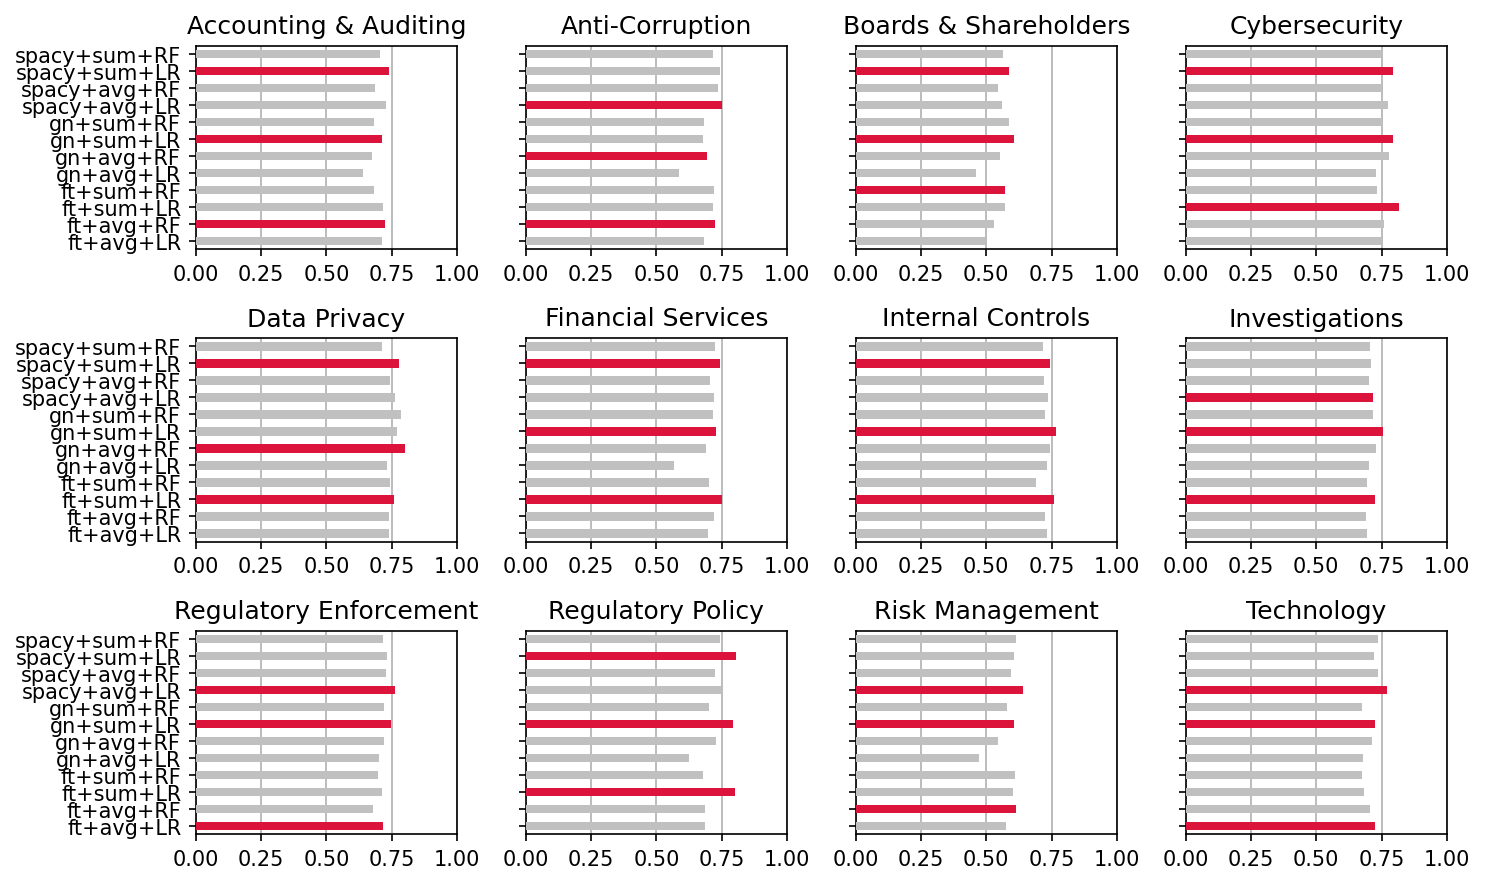

In [19]:
results_df = pd.DataFrame(results, columns=['topic', 'word_embedding', 'agg_method', 'clf', 'accuracy']).dropna()
results_df['model_desc'] = results_df.drop(['topic', 'accuracy'], axis=1).apply(lambda x: '+'.join(x), axis=1)
results_df = pd.pivot(results_df, index='topic', columns=['model_desc'], values=['accuracy'])
results_df.columns =results_df.columns.droplevel(0)

fig, ax = plt.subplots(nrows=3, ncols=4, dpi=150, figsize=[10,6], sharey=True)
axes = ax.flatten()
cols =  results_df.columns


for i, topic in enumerate(topic_cols):
    colors = ['silver']*len(cols)
    temp_dict = [(col.split('+')[0], results_df.loc[topic, col]) for col in results_df.columns]
    j = 0
    for tag, group in groupby(temp_dict, lambda x:x[0]):
        idx = np.array(list(zip(*group))[1]).argmax()+j
        colors[idx] = 'crimson'
        j+=4
    
    results_df.loc[topic, cols].plot.barh(ax=axes[i], color=colors, zorder=10)
    axes[i].set_title(topic)
  #  axes[i].set_yticklabels(['Spacy(Sum)+RF', 'Google(Sum)+RF', 'Fasttext(Sum)+RF', 'Spacy(AVG)+RF', 'Spacy(AVG)+LR', 'Spacy(AVG)+RF', 'Fasttext(AVG)+RF'])
    axes[i].set_xlim(0,1)
    axes[i].set_ylabel('')
    axes[i].grid(axis='x', zorder=5)
    
plt.tight_layout()

### Train models again, evaluate f1 score on the testing set

In [20]:
model_dict = {'RF': RandomForestClassifier(), 'LR': LogisticRegression()}
results_test = []
from sklearn.metrics import f1_score

topic_model_dict = defaultdict(dict)
agg_dict = defaultdict(dict)

for embedding in nlp_dict.keys():
    best_mod_by_topic = results_df[results_df.columns[results_df.columns.str.contains(embedding)]]
    best_mod_by_topic = best_mod_by_topic.apply(lambda x: best_mod_by_topic.columns[x.argmax()], axis=1)
    print(embedding)
    for topic in best_mod_by_topic.index:
        _, agg_method, clf = re.split(r'[()+]+', best_mod_by_topic[topic])
        X_train = train_data_dict[topic][embedding][agg_method]['X']
        y_train = train_data_dict[topic][embedding][agg_method]['y']
        X_test = test_data_dict[topic][embedding][agg_method]['X']
        y_test = test_data_dict[topic][embedding][agg_method]['y']
        
        model = model_dict[clf]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        results_test.append([topic, embedding, f1])
        
        print('{:<25}:{:.4f}'.format(topic, f1))
        
        topic_model_dict[topic][embedding] = model
        agg_dict[topic][embedding] = agg_method
        
    print('\n')

spacy
Accounting & Auditing    :0.8000
Anti-Corruption          :0.0000
Boards & Shareholders    :0.2857
Cybersecurity            :0.5000
Data Privacy             :0.6667
Financial Services       :0.3529
Internal Controls        :0.5714
Investigations           :0.3636
Regulatory Enforcement   :0.1667
Regulatory Policy        :0.4211
Risk Management          :0.0000
Technology               :0.0000


ft
Accounting & Auditing    :0.0000
Anti-Corruption          :0.0000
Boards & Shareholders    :0.3333
Cybersecurity            :0.5556
Data Privacy             :0.5263
Financial Services       :0.4706
Internal Controls        :0.7143
Investigations           :0.5333
Regulatory Enforcement   :0.0000
Regulatory Policy        :0.6667
Risk Management          :0.0000
Technology               :0.0000


gn
Accounting & Auditing    :0.6667
Anti-Corruption          :0.0000
Boards & Shareholders    :0.4211
Cybersecurity            :0.7368
Data Privacy             :0.4615
Financial Services       :0

#### Save all models (if necssary)

In [10]:
# # Save models and aggregation method dictionaries
# import pickle 
# import json

# for topic, value in topic_model_dict.items():
#     for embedding, model in value.items():
#         path = 'topic_classifiers/{}_Classifier_{}_1124.pkl'.format(topic, embedding)
#         with open(path, 'wb') as f:
#             pickle.dump(topic_model_dict[topic], f)   
            
# path = 'topic_classifiers/aggmethod_dict_1124.json'
# with open(path, 'w') as f:
#     json.dump(agg_dict, f)

# Apply classification models to unlabelled data

#### Load embeddings (if necessary)

In [11]:
# # Load embeddings
# from gensim.models import KeyedVectors
# import spacy

# nlp_dict = {}
# nlp_dict['spacy'] = en_core_web_lg.load()

# gn_path = r'googlenews_we/GoogleNews-vectors-negative300.bin'
# gn_model = KeyedVectors.load_word2vec_format(gn_path, binary=True)
# nlp_dict['gn'] = spacy.blank('en')
# nlp_dict['gn'].vocab.vectors = spacy.vocab.Vectors(data=gn_model.vectors, keys=gn_model.index2word)

# ft_path = r'fasttext/wiki.en/wiki.en.vec'
# ft_model = KeyedVectors.load_word2vec_format(ft_path, binary=False)
# nlp_dict['ft'] = spacy.blank('en')
# nlp_dict['ft'].vocab.vectors = spacy.vocab.Vectors(data=ft_model.vectors, keys=ft_model.index2word)

# def get_word_embedding(nlp, tokenized_doc, agg_method='avg'):
#     if agg_method == 'avg':
#         word_embedding = nlp(' '.join(tokenized_doc)).vector
        
#     elif agg_method == 'sum':
#         word_embedding = np.array([nlp(word).vector for word in tokenized_doc]).sum(axis=0)   
        
#     return word_embedding

#### Load models (if necessary)

In [12]:
# # Load models and aggregation method dictionaries
# path = 'topic_classifiers/aggmethod_dict_1124.json'
# with open(path, 'r') as f:
#     agg_dict = json.load(f)


# topic_model_dict =  defaultdict(dict)

# for topic in topic_cols:
#     for embedding in nlp_dict.keys():
#         path = 'topic_classifiers/{}_Classifier_{}_1124.pkl'.format(topic, embedding)
#         with open(path, 'rb') as f:
#             topic_model_dict[topic][embedding] = pickle.load(f)

### Make predictions

In [21]:
def predict_catgory(vector_dict, topic, topic_model_dict, agg_dict, threshold=3):
    topic_model_dict = topic_model_dict[topic]
    agg_dict = agg_dict[topic]
    n = [len(vv)  for v in unlabelled_vectors_dict.values() for vv in v.values()][0]
    vote = np.zeros(n)
    
    for embedding in topic_model_dict.keys():
        X_test = vector_dict[embedding][agg_dict[embedding]]
        y_pred = topic_model_dict[embedding].predict(X_test)
        vote[y_pred == 1] += 1
                   
    pred = (vote >= threshold).astype('int')
        
    return pred

In [43]:
unlabelled_vectors_dict['spacy']['avg'].shape

(1824, 300)

In [47]:
nlp_dict['ft']

TypeError: 'English' object is not subscriptable

In [23]:
# Import unlabelled data
df = pd.read_csv('Compliance_data_1113.csv').rename({'Paragrah':'Paragraph'}, axis=1)
df['text'] = np.nan
df.loc[(~df.Summary.isna()), 'text'] = df['Headline']+ '. ' + df['Summary']
df.loc[(~df.Paragraph.isna()) & (df.Summary.isna()), 'text'] = df['Headline']+ '. ' + df['Paragraph']
df.loc[(df.Summary.isna()), 'text'] = df['Headline']

# Preprocessing
tokenized_docs = normalize_corpus(df['text'])

# Transform articles into word embeddings
unlabelled_vectors_dict = defaultdict(dict)

for embedding in nlp_dict.keys():
    for method in ['avg', 'sum']:
        unlabelled_vectors_dict[embedding][method] = np.array([get_word_embedding(nlp_dict[embedding], news, method) for news in tokenized_docs])
        
# Use hard voting mehtod to predict categories 
for topic in topic_cols:
    df[topic] = predict_catgory(unlabelled_vectors_dict, topic, topic_model_dict, agg_dict, threshold=3)
    
df['category'] = df.loc[:, topic_cols].apply(lambda x: np.array(df.loc[:, topic_cols].columns)[np.array(x).nonzero()[0]], axis=1)

KeyboardInterrupt: 

### Randomly pick up news to examine the results

In [38]:
df_temp = df.loc[df['category'].apply(lambda x: len(x)) !=0]

for i in random.sample(list(df_temp.index), 10):
    print(i)
    print(df_temp.loc[i, 'category'])
  #  print(df_temp.loc[i, 'Headline'])
    print(df_temp.loc[i, 'text'])
    print('\n')

1178
['Accounting & Auditing' 'Boards & Shareholders' 'Risk Management']
At Large: Give compliance officers more power


243
['Accounting & Auditing' 'Risk Management']
New Deals in Health Care: Ecosystem Partnerships. ×Just as fintech disrupted financial services, “healthtech” is on the verge of transforming health care.
The definition of health care M&A is expanding to include alliances, partnerships, and joint ventures that would have been considered unlikely a decade ago.
A rise in consumerism is converging with margin pressures and new technologies to drive health care providers in search of new business models.
Individualized financers would offer modular health coverage packages and reduce health care costs.
Some organizations may find partnerships, alliances, mergers, or even divestitures necessary—and these deals could involve organizations that are not traditionally regarded as health care companies.


844
['Boards & Shareholders']
J.P. Morgan to Launch Electronic FX Engine i

# Second-Round Training: Pseudo Labeling(Semi-supervised Learning)

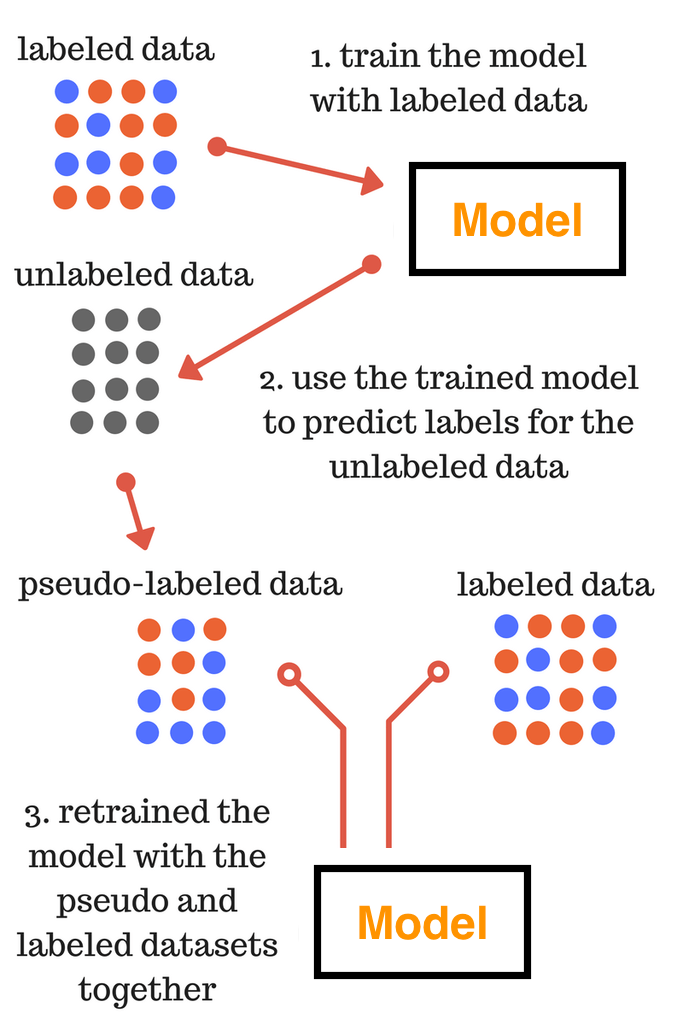
* Source: [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2017/09/pseudo-labelling-semi-supervised-learning-technique/)

### 1. Get the best model for each kind of embedding and each topic

In [39]:
best_mod_list = []

for embedding in nlp_dict.keys():
    best_mod_by_topic = results_df[results_df.columns[results_df.columns.str.contains(embedding)]]
    best_mod_by_topic = best_mod_by_topic.apply(lambda x: best_mod_by_topic.columns[x.argmax()], axis=1)
    for topic in best_mod_by_topic.index:
        _, agg_method, clf = re.split(r'[()+]+', best_mod_by_topic[topic])
        best_mod_list.append([topic, embedding, agg_method, clf])
        
best_mod = pd.DataFrame(best_mod_list, columns=['topic', 'embedding', 'agg_method', 'clf'])
best_mod.loc[best_mod.topic == 'Accounting & Auditing']

,topic,embedding,agg_method,clf
0,Accounting & Auditing,spacy,sum,LR
12,Accounting & Auditing,ft,avg,RF
24,Accounting & Auditing,gn,sum,LR


### 2. Define a function to acquire data

In [40]:
# Define a function to acquire train data based on specific topic, embedding and aggregation method
def update_train_data(train_data_dict, unlabelled_vectors_dict, sample_idx):
    
    train_data_dict2 = defaultdict(dict)
    for topic in topic_cols:           
        for embedding in nlp_dict.keys():
            train_data_dict2[topic][embedding] = defaultdict(dict)
            for method in ['avg', 'sum']:       
                pseudo_X = unlabelled_vectors_dict[embedding][method][sample_idx]
                pseudo_y = df[topic][sample_idx]

                labelled_X = train_data_dict[topic][embedding][method]['X']
                labelled_y = train_data_dict[topic][embedding][method]['y']

                train_data_dict2[topic][embedding][method]['X'] = np.r_[labelled_X, pseudo_X]
                train_data_dict2[topic][embedding][method]['y'] = np.r_[labelled_y, pseudo_y]
                
    return train_data_dict2


### 3. Train models again

In [41]:
results_test2 = []

for sample_ratio in np.arange(.25, 1.1, .25):
 #   print(sample_ratio)
    # Randomly sample pseudo_labelled data
   # sample_ratio = .2
    random.seed(399)
    sample_idx = random.sample(list(df.index), int(len(df)*sample_ratio))


    # Update the training set by adding psudo_labelled data
    train_data_dict2 = update_train_data(train_data_dict, unlabelled_vectors_dict, sample_idx)
    
    col_name = 'add_{:.0%}_pseudo'.format(sample_ratio)
    best_mod[col_name] = np.nan
    
    topic_model_dict2 = defaultdict(dict)

    
    for topic in topic_cols:
        best_mod_for_topic = best_mod.loc[best_mod.topic == topic]
        
        for i, row in best_mod_for_topic.iterrows():
            embedding = row['embedding']
            agg_method = row['agg_method']
            clf = model_dict[row['clf']]
            
            X_train = train_data_dict2[topic][embedding][agg_method]['X']
            y_train = train_data_dict2[topic][embedding][agg_method]['y']
            X_test = test_data_dict[topic][embedding][agg_method]['X']
            y_test = test_data_dict[topic][embedding][agg_method]['y']

            model = clf
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            f1 = f1_score(y_test, y_pred)
            
            best_mod.loc[i, col_name] = f1
            
            results_test2.append([topic, embedding, f1, sample_ratio])

         #   print('{:<25}:{:.4f}'.format(topic, f1))

            topic_model_dict2[topic][embedding] = model


    #    print('\n')

### 4. Observe the difference in performance based on varying sample ratios

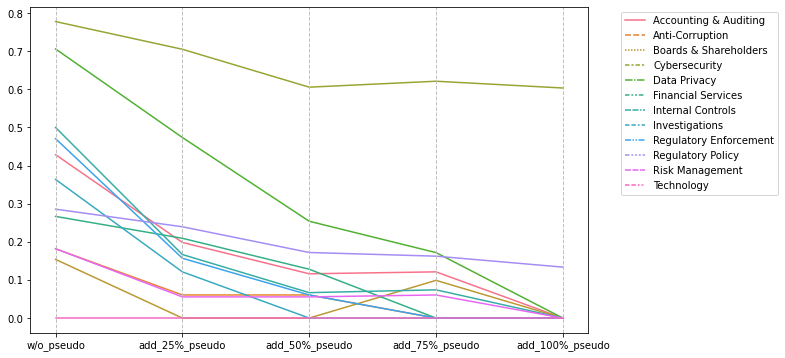

In [32]:
test_results_df2 = pd.DataFrame(results_test2, columns=['topic', 'embedding', 'f1', 'sample_ratio'])
sample_ratio_compare = test_results_df2.groupby(['topic', 'sample_ratio'])['f1'].mean().reset_index()
sample_ratio_compare = pd.pivot(sample_ratio_compare, index='topic', columns=['sample_ratio'], values='f1')
sample_ratio_compare['w/o pseudo'] = test_results_df2.groupby(['topic'])['f1'].max()
sample_ratio_compare.columns = ['add_25%_pseudo', 'add_50%_pseudo', 'add_75%_pseudo', 'add_100%_pseudo', 'w/o_pseudo']
sample_ratio_compare = sample_ratio_compare[['w/o_pseudo', 'add_25%_pseudo', 'add_50%_pseudo', 'add_75%_pseudo', 'add_100%_pseudo']]

fig, ax = plt.subplots(figsize=[10,6])
sns.lineplot(data=sample_ratio_compare.T, ax=ax)
for i in range(12):
    ax.lines[i].set_linestyle("-")
    
for i in range(5):
    ax.axvline(i, color='silver', linestyle='--', linewidth=1)
    
ax.legend(bbox_to_anchor=(1.05, 1))